<a id="top"></a>

# Models

---

This notebook is for the modeling and interpretation of the data, in the interest of accurately classifying the differences between the DnDNext and Pathfinder_RPG subreddits. This would be accomplished with bar of words natural language processing using count vectorizers and a selection of classification models. The largest issue when modeling this data was the exceptionally high variance. This was addressed initially with hyperparameter tuning, then by adding to the stop words by examining the count vectors.

#### This Notebook

- [Subtracting Vecorizers](#vec)
- [Model Comparisons](#comp)
- [Further Vector Observations](#vec2)
- [Interpretations](#interp)
- [Final Testing](#fin)

#### Other Notebooks
- [Data Gathering](gathering.ipynb)
- [Data Cleaning and EDA](cleaning_and_EDA.ipynb)

### Importing
---

In [687]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [471]:
# `final` is the dataframe that contains both the testing
# and training data from DnDNext and Pathfinder_RPG. `alt`
# contains data from DnDBehindTheScreen and Pathfinder,
# making the data similar but coming from a different source.

final = pd.read_csv("../data/final.csv")
alt = pd.read_csv("../data/alt.csv")

In [188]:
final.head()

,has_unique_domain,has_media,num_comments,score,selftext,subreddit,title
0,0,0,414,17,New weekly question threads will be automatica...,dndnext,Weekly Question Thread: Ask questions here Mar...
1,0,0,1,6,"Got a pic of your dice, minis, table or just s...",dndnext,"Snapshots: post pics! March 30, 2019"
2,0,0,26,87,It is an optional rule on page 263 of the DMG....,dndnext,"Has anyone tried the ""Ability Check Proficienc..."
3,0,0,41,64,Hello!\n\nI played D&amp;D with friends in mid...,dndnext,Wanting to try D&amp;D again. It's been 25 years.
4,0,0,100,964,"They were supposed to level up, become heroes ...",dndnext,"It finally happened, they ended up in jail"


### Splitting
---

Because the training and testing data was merged during cleaning and exported as one dataframe, the dataframe is split here and the subreddit is remapped to 1s and 0s.

In [189]:
# Finding the index at which to split the whole dataframe before mapping

split_index = (final[(final["subreddit"] == "dndnext") |
                     (final["subreddit"] == "Pathfinder_RPG")].index).max()

In [190]:
# Mapping DnDNext to 1 and Pathfinder_RPG to 0

final["subreddit"] = final["subreddit"].map({'Pathfinder_RPG': 0, 'dndnext': 1, 
                                             'dndnext_test': 1, 'pathfinder_test': 0})

In [191]:
# Splitting into a training and testing data frame

df = final.iloc[:(split_index + 1), :]

df_test = final.iloc[(split_index + 1):, :]

<a id = "vec"></a>

## Subtracting Vectorizers
---

The goal of this section is to fit a vecorizer to our total data to find the 1000 most common words, then transform all of our data grouped by subreddit to find the word sum count for each of the 1000 words. The sums are then subtracted from each other, giving us the diffence in word counts which shows the most common words for each subreddit by absolute value. Negative values pertain to the Pathfinder_RPG subreddit, while positive values correspond to the DnDNext subreddit.

While the code is mine, the orginal idea for vector subtractions came from Patrick; I feel compelled to credit him because these operations informed many of my personal insights derived from the data.

After preliminary modeling, I continued to examine the vectors in [Further Vector Observations](#vec2).

[Back to top](#top)

In [585]:
features = ["selftext"]

X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [586]:
dnd_vec = df[df["subreddit"] == 1]["selftext"]
path_vec = df[df["subreddit"] == 0]["selftext"]

In [587]:
cvec = CountVectorizer(max_features = 1000,
                       stop_words = "english")

X_cvec = pd.DataFrame(cvec.fit_transform(X).todense(), 
                      columns = cvec.get_feature_names())

dnd_vec = pd.DataFrame(cvec.transform(dnd_vec).todense(), 
                       columns = cvec.get_feature_names())

path_vec = pd.DataFrame(cvec.transform(path_vec).todense(), 
                        columns = cvec.get_feature_names())

In [588]:
vec = dnd_vec.sum() - path_vec.sum()

In [589]:
vec.sort_values()

com              -266
feats            -232
amp              -226
https            -213
www              -200
pathfinder       -192
d20pfsrd         -191
paizo            -180
gm               -174
build            -146
spell            -132
x200b            -124
level            -120
feat             -116
archetype        -105
pathfinder_rpg    -90
aonprd            -90
archetypes        -90
classes           -89
aspx              -88
search            -85
does              -85
summoner          -82
use               -81
combat            -81
restrict_sr       -80
alchemist         -79
skill             -79
evil              -68
reddit            -68
                 ... 
feature            41
proficiency        41
drow               42
barbarian          42
cast               43
think              45
roll               45
new                46
subclass           47
saving             47
rest               48
damage             50
tools              50
cleric             50
make      

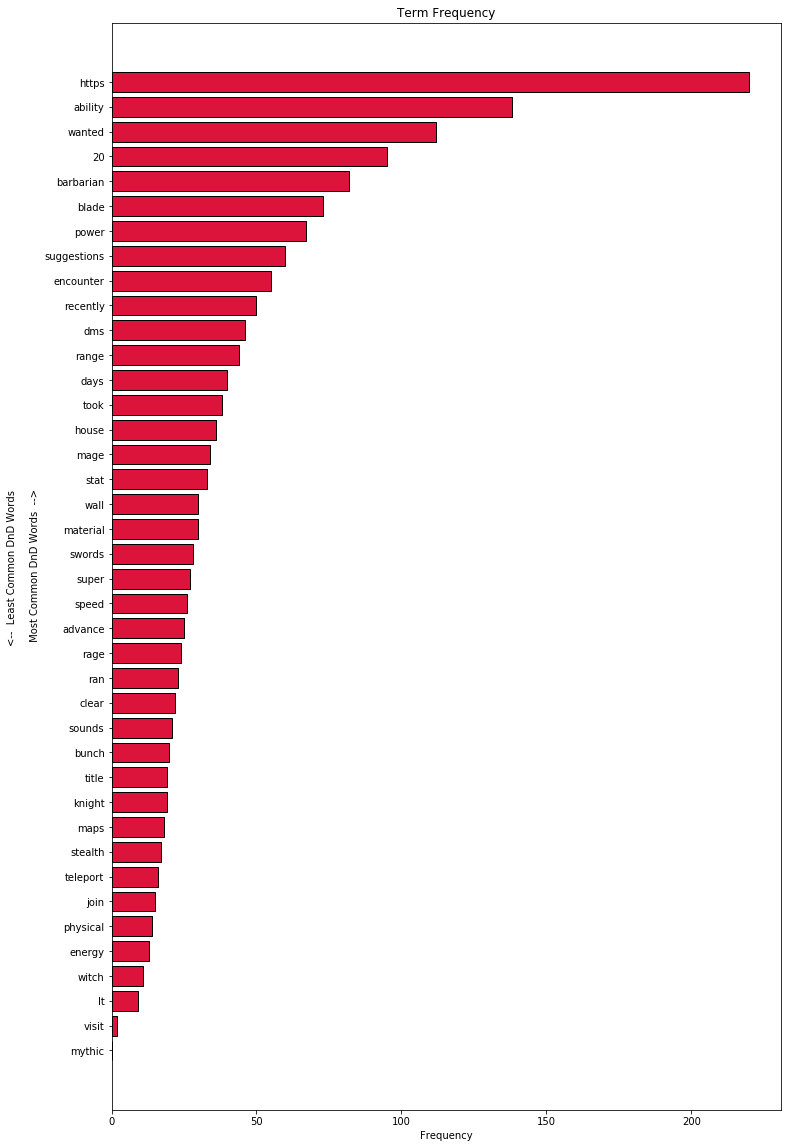

In [608]:
plt.figure(figsize = (12,20))
for i in range(0, 1000, 25):
    plt.barh(dnd_vec.sum().sort_values().index[i], 
             dnd_vec.sum().sort_values()[i],
             color = "crimson",
             edgecolor = "k");
    
plt.ylabel("<--  Least Common DnD Words \n\n Most Common DnD Words  -->")
plt.xlabel("Frequency")
plt.title("Term Frequency");

plt.savefig("../images/dnd_term_frequency_untrimmed.png")

> Visualization of the most common words from the DnDNext subreddit before trimming. These are (obviously) not the only words, but this shows the shape of the sums. Note that the highest word is https, an artifact from a hyperlink. While common, these do not carry any information about the subreddit, similar to a stop word. These mwill be trimmed out in the following section.

In [604]:
path_vec.sum().sort_values(ascending = False)

amp          800
level        621
like         560
spell        543
x200b        519
just         512
com          475
https        433
character    402
use          386
make         340
party        310
ve           304
www          296
players      293
time         292
game         291
want         284
spells       274
know         268
campaign     263
feats        262
don          261
damage       261
good         257
magic        250
new          235
does         232
way          230
attack       227
            ... 
advantage      9
okay           9
leader         9
white          9
guard          9
enjoy          9
bear           9
slots          9
silver         9
blast          9
speak          8
dms            8
luck           7
pact           6
warlock        6
view           5
variant        5
minions        5
cantrip        5
reaction       5
beginning      5
cards          4
tool           3
swords         2
cantrips       2
tools          1
cassandra      0
subclass      

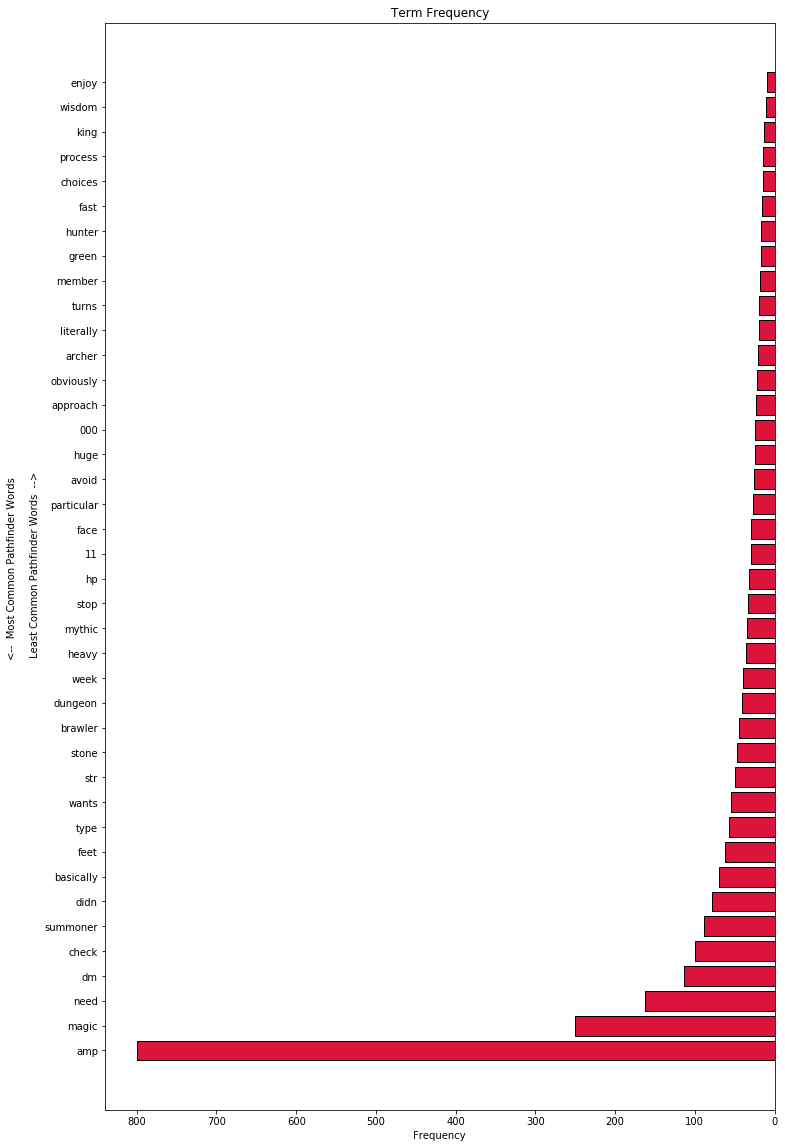

In [637]:
plt.figure(figsize = (12,20))
for i in range(0, 1000, 25):
    plt.barh(path_vec.sum().sort_values(ascending = False).index[i], 
             path_vec.sum().sort_values(ascending = False)[i],
             color = "crimson",
             edgecolor = "k");
    
plt.ylabel("<--  Most Common Pathfinder Words \n\n Least Common Pathfinder Words  -->")
plt.xlabel("Frequency")
plt.title("Term Frequency")


plt.gca().invert_xaxis();

plt.savefig("../images/path_term_frequency_untrimmed.png")

> The same chart but for Pathfinder. This one is flipped on its side to mimic the shape of the subtracted vectors, which is generated further down the notebook.

In [206]:
# Pruning more words out of the model to hopefully cut back
# on the amout of words that contain little value. These
# words are mostly artifacts from links posted within the 
# subreddits and not from the content of the posts themselves.

# Doing this will negatively impact our scores; some of these
# words, (amp, aspx, x200b) contain no interpretable information 
# but are highly correlated with the Pathfinder_RPG subreddit
# because sharing links is more common in the Pathfinder reddit
# than in the DnD reddit. 

# Despite actively making future models worse by removing
# identifiable words, it seems right to do so because these
# words don't include an human interpretable information.
# However, one might argue that the presence of links is a
# human interpretable piece of information.

more_stop_words = {"com", "feats", "amp", 
                   "https", "www", "aspx", 
                   "x200b", "restrict_sr", 
                   "pathfinder_rpg", "dndnext"}

In [207]:
# [df["selftext"][i] for i in range(len(df["selftext"])) if "Pathfinder_RPG" in df["selftext"][i]]

In [208]:
# Hand-selected stop words added to the english dictionary
# of stop words from nltk. Code taken from Charlie's word 
# cloud lesson. Thank you Charlie!

stop = stopwords.words('english')
stop = {x.lower() for x in stop}
stop = stop|more_stop_words

In [209]:
features = ["selftext"]

X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

dnd_vec = df[df["subreddit"] == 1]["selftext"]
path_vec = df[df["subreddit"] == 0]["selftext"]

cvec = CountVectorizer(max_features = 1000,
                       stop_words = stop)
                       #ngram_range = (1,2))

X_cvec = pd.DataFrame(cvec.fit_transform(X).todense(), 
                      columns = cvec.get_feature_names())

dnd_vec = pd.DataFrame(cvec.transform(dnd_vec).todense(), 
                       columns = cvec.get_feature_names())

path_vec = pd.DataFrame(cvec.transform(path_vec).todense(), 
                        columns = cvec.get_feature_names())

vec = dnd_vec.sum() - path_vec.sum()
vec.sort_values()

pathfinder   -192
d20pfsrd     -191
paizo        -180
gm           -174
build        -146
spell        -132
level        -120
feat         -116
archetype    -105
archetypes    -90
aonprd        -90
classes       -89
search        -85
summoner      -82
combat        -81
use           -81
alchemist     -79
skill         -79
evil          -68
reddit        -68
22            -67
sort          -65
round         -63
per           -60
oracle        -60
discussion    -59
animal        -59
flair         -59
title         -57
itemname      -57
             ... 
drow           42
cast           43
think          45
roll           45
without        45
new            46
saving         47
subclass       47
rest           48
damage         50
cleric         50
tools          50
make           53
hit            53
sword          54
see            56
wizard         57
pact           60
dnd            64
artificer      66
turn           67
bard           70
player         70
one            71
players   

<a id = "comp"></a>
## Model Comparisons
---

These are the preliminary models used to find which model will give me the most accurate results. As I, and many others have found, the main issue when modeling with bag of words models is the high variance. Most of the models had not trouble getting training scores of 90% or higher, but the cross validation and subsequent test scores were almost always around the mid 70s. Eventually, it seemed that hyperparameter tuning could only do so much to to reduce the variance, so I went back to the drawing board with the vectorizers to reduce the variance by trimming out some of the features. 

The model that I decided to use for further analysis and the presentation was the Multinomial Naive Bayes model. Although the training scores were not as high as some of the other models, the scores themselves were closer together than any of the other models, meaning I had a lower baseline variance to reduce.

All scores are measured in accuracy. This is because both unbalanced classes and misclassification are not issues, as incorrectly identifying one subreddit from the other does not have much of a real world impact. 

- [Naive Bayes](#multinb)
- [Trees](#trees)
- [Support Vector Machines](#svm)
- [Logistic Regression](#logreg)
- [Optimizing the Naive Bayes model](#nb2)


[Back to top](#top)

<a id = "multinb"></a>
    
### Naïve Bayes
---

[Back to Model Comparisons](#comp)

In [192]:
X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [274]:
# Baseline accuracy score

y.value_counts(normalize = True)

1    0.500252
0    0.499748
Name: subreddit, dtype: float64

In [194]:
cvec = CountVectorizer(max_features = 1000,
                       stop_words = "english")

X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                            columns = cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(), 
                           columns = cvec.get_feature_names())

nb = MultinomialNB()
nb.fit(X_train_cvec, y_train)

print(f"Naive Bayes Model Training Score:\t {nb.score(X_train_cvec, y_train)}")
print(f"Naive Bayes Model Testing Score:\t {nb.score(X_test_cvec, y_test)}")

Naive Bayes Model Training Score:	 0.8168350168350168
Naive Bayes Model Testing Score:	 0.7681451612903226


In [195]:
cross_val_score(nb, X_train_cvec, y_train, cv = 5).mean()

0.74002416082953

In [196]:
X_train_cvec.sum().sort_values(ascending = False)

amp            1012
level           897
like            859
just            815
spell           710
character       659
x200b           652
make            566
com             553
https           529
use             500
party           484
players         482
ve              464
want            453
damage          444
know            421
time            411
campaign        403
game            397
don             397
new             395
spells          389
attack          362
magic           355
dm              343
think           339
good            333
way             329
weapon          328
               ... 
gallery          23
dispel           23
gms              23
dies             23
cave             23
ap               23
tactics          23
sun              23
suggest          23
succeed          23
bigger           23
souls            23
smite            23
tricks           23
monkey           23
scorching        23
result           23
originally       23
utility          23


<a id = "trees"></a>

### Random and Extreme Trees
---
[Back to Model Comparisons](#comp)

In [214]:
X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [242]:
pipe = Pipeline([
                ("cvec", CountVectorizer(stop_words = stop)),
                ("et", ExtraTreesClassifier(random_state = 35))
                ])

params = {
    "cvec__max_features": [1500, 2000],
    # "cvec__stop_words":   [stop],
    
    "et__n_estimators": [75, 78],
    "et__max_depth": [5, 10, 25],
    "et__max_features": [60, 65],
    "et__min_samples_split": [5]
}

grid = GridSearchCV(pipe, param_grid = params, cv = 3, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

---------------------------------------- 

Train score: 	0.9265993265993266
Test score:  	0.7963709677419355

Best params: 	{'cvec__max_features': 1500, 'et__max_depth': 25, 'et__max_features': 60, 'et__min_samples_split': 5, 'et__n_estimators': 78}

----------------------------------------


In [240]:
pipe = Pipeline([
                ("cvec", CountVectorizer(stop_words = stop)),
                ("rf", RandomForestClassifier(random_state = 35))
                ])

params = {
    "cvec__max_features": [2500],
    # "cvec__stop_words":   [stop],
    
    "rf__n_estimators": [78],
    "rf__max_depth": [25],
    "rf__max_features": [60],
    #"rf__min_samples_split": [2, 5, 10]
    #"bootstrap": []
}

grid = GridSearchCV(pipe, param_grid = params, cv = 3, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

---------------------------------------- 

Train score: 	0.9427609427609428
Test score:  	0.7923387096774194

Best params: 	{'cvec__max_features': 2500, 'rf__max_depth': 25, 'rf__max_features': 60, 'rf__n_estimators': 78}

----------------------------------------


<a id = "svm"></a>

### Support Vector Machine
---
[Back to Model Comparisons](#comp)

In [216]:
X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [218]:
pipe = Pipeline([
                ("cvec", CountVectorizer()),
                ("svm", svm.SVC())
                ])

params = {
    "cvec__max_features": [1000, 1500],
    "cvec__stop_words":   [stop],
    #"cvec__ngram_range":  [(1,1)]
    
    "svm__kernel": ["linear", "poly", "sigmoid"],
    "svm__C":      [0.1, 1, 10]
}

grid = GridSearchCV(pipe, param_grid = params, cv = 3, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


---------------------------------------- 

Train score: 	0.835016835016835
Test score:  	0.75

Best params: 	{'cvec__max_features': 1000, 'cvec__stop_words': {"you'd", 'but', 'yourself', 'for', 'to', 'same', 'shan', 'wasn', 'would', 'one', 'pathfinder_rpg', 'a', 'too', 'the', 'them', 'only', 'on', 'm', 'amp', "she's", 'these', 'because', 'be', 'himself', 'me', 'if', 'how', 'both', 'having', 'y', 'then', 'should', 'no', "hadn't", "doesn't", 'at', 'whom', 'once', 's', 'herself', 'itself', 'above', 'again', 'that', 'myself', 'what', 'ours', 'themselves', 'out', 'against', "didn't", 'did', 'd', 'its', 'mustn', 'with', "shan't", 'nor', 'is', 't', "that'll", 'isn', 'than', 'have', "you'll", 'each', 'are', 'wouldn', 'such', 'has', 'just', "hasn't", 'dndnext', 'won', "haven't", 'between', 'restrict_sr', 'their', 'he', 'now', "needn't", 'was', "don't", 'very', 'up', 'didn', 'after', 'which', 'off', "couldn't", 'as', 'like', 'yours', 'couldn', "won't", 'who', 'it', "shouldn't", 'during', 'don', 

<a id = "logreg"></a>

### Logistic Regression
---
[Back to Model Comparisons](#comp)

In [448]:
X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [449]:
pipe = Pipeline([
                ("cvec", CountVectorizer(stop_words = stop)),
                ("logreg", LogisticRegression())
                ])

params = {
    "cvec__max_features": [1000],
    
    #"logreg__C": [0.01, 0.05, 0.1, 0.2 ]
}

grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


---------------------------------------- 

Train score: 	0.9649831649831649
Test score:  	0.75

Best params: 	{'cvec__max_features': 1000}

----------------------------------------


<a id = "nb2"></a>

### Optimizing the Naive Bayes model
---

[Back to Model Comparisons](#comp)

In [450]:
X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [451]:
pipe = Pipeline([
                ("cvec", CountVectorizer(stop_words = stop)),
                ("nb", MultinomialNB())
                ])

params = {
    "cvec__max_features": [3000],
    
    "nb__alpha": [1.0, 0.1, 5]
}

grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

---------------------------------------- 

Train score: 	0.8888888888888888
Test score:  	0.8125

Best params: 	{'cvec__max_features': 3000, 'nb__alpha': 0.1}

----------------------------------------


In [327]:
pipe = Pipeline([
                ("tvec", TfidfVectorizer(stop_words = stop)),
                ("nb", MultinomialNB())
                ])

params = {
    "tvec__max_features": [3000, 3500],
    
    "nb__alpha": [0.1]
}

grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

---------------------------------------- 

Train score: 	0.9562289562289562
Test score:  	0.8084677419354839

Best params: 	{'nb__alpha': 0.1, 'tvec__max_features': 3000}

----------------------------------------


<a id = "vec2"></a>

## Further Vectorizer Observations
---

As I continued to examine the vectors, I began to consider how these vectors imitate a Venn diagram. The words with a higher abolute value are pushed towards the unique bounds of the circles, whereas the words that are common between them populate the overlap between the circles.

Operations continued from [Subtracting Vectorizers](#vec).

[Back to top](#top)

In [278]:
# Printing out the subtracted vector again

vec.sort_values()

pathfinder   -192
d20pfsrd     -191
paizo        -180
gm           -174
build        -146
spell        -132
level        -120
feat         -116
archetype    -105
archetypes    -90
aonprd        -90
classes       -89
search        -85
summoner      -82
combat        -81
use           -81
alchemist     -79
skill         -79
evil          -68
reddit        -68
22            -67
sort          -65
round         -63
per           -60
oracle        -60
discussion    -59
animal        -59
flair         -59
title         -57
itemname      -57
             ... 
drow           42
cast           43
think          45
roll           45
without        45
new            46
saving         47
subclass       47
rest           48
damage         50
cleric         50
tools          50
make           53
hit            53
sword          54
see            56
wizard         57
pact           60
dnd            64
artificer      66
turn           67
bard           70
player         70
one            71
players   

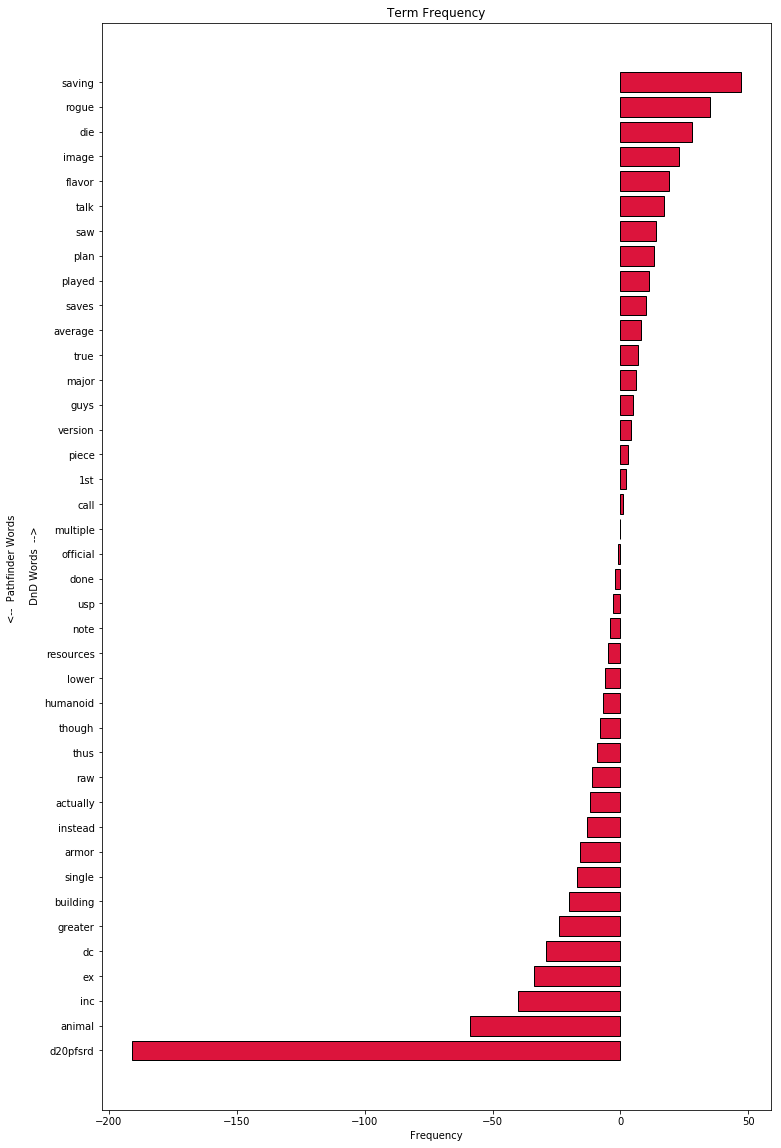

In [582]:
plt.figure(figsize = (12,20))
for i in range(1, 1000, 25):
    plt.barh(vec.sort_values().index[i], 
             vec.sort_values()[i],
             color = "crimson",
             edgecolor = "k");
    
plt.ylabel("<--  Pathfinder Words \n\n DnD Words  -->")
plt.xlabel("Frequency")
plt.title("Term Frequency");

plt.savefig("../images/term_frequency.png")

> Simple visialization of the subtracted vectorizors. The number of features has been pared down in the interest of readability, but the overall shape of the vectors remains the same.


In [258]:
# Words that occur an equal amount of times in each dataset;
# note that this does not give any information about the 
# total ocurrences at all. These words are what would 
# populate the middle section of a Venn diagram.

vec[vec == 0]

ago           0
built         0
cave          0
fact          0
fit           0
grab          0
include       0
initiative    0
killing       0
lead          0
limited       0
low           0
multiple      0
page          0
play          0
prepare       0
reach         0
unless        0
dtype: int64

In [626]:
# The top words overall. If a word shows up near the top 
# it is very common but not necessarily more common to 
# either subreddit. If it is high up but has a value near
# zero in the subtracted data set 

most_common = X_cvec.sum().sort_values(ascending = False)[0:500]
most_common

amp          1374
like         1150
level        1122
just         1049
spell         954
x200b         914
character     890
make          733
use           691
com           684
players       659
https         653
party         652
ve            610
want          609
damage        572
game          551
know          547
time          543
campaign      528
spells        525
don           518
new           516
good          470
magic         464
attack        464
think         451
dm            450
really        438
weapon        427
             ... 
raw            61
mage           61
backstory      61
lt             61
bring          61
wrong          61
talking        60
hope           60
reach          60
ago            60
strong         60
easy           60
dark           60
hunter         60
3rd            60
eldritch       60
outside        60
oracle         60
lets           60
core           60
wizards        59
usually        59
goes           59
super          59
races     

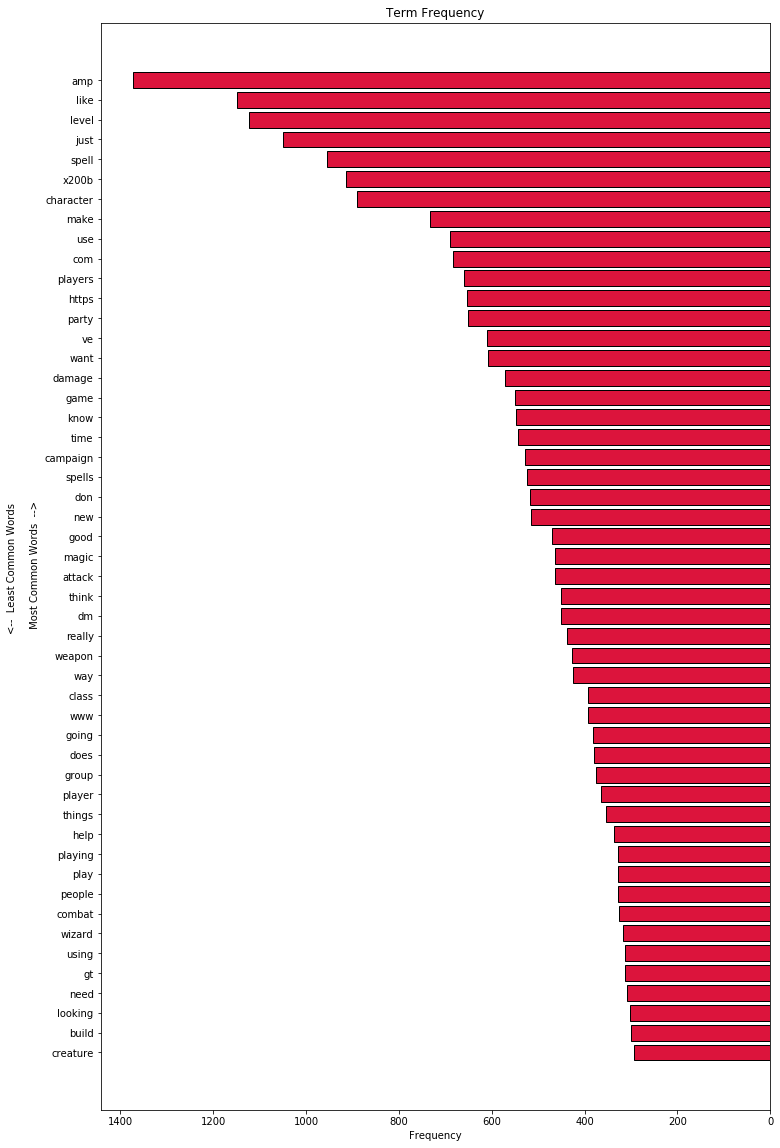

In [635]:
plt.figure(figsize = (12,20))
for i in range(0, 50, 1):
    plt.barh(most_common.sort_values(ascending = False).index[i], 
             most_common.sort_values(ascending = False)[i],
             color = "crimson",
             edgecolor = "k");
    
plt.ylabel("<--  Least Common Words \n\n Most Common Words  -->")
plt.xlabel("Frequency")
plt.title("Term Frequency")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis();

plt.savefig("../images/most_common_term_frequency_untrimmed.png")

> Visualization of the 50 most common words overall. Many of the top words contain little meaning and are added to the stop words list so they will not interfere with the models.

In [368]:
# Taking the top 500 words and seeing which of them occur 
# near the middle of the subtracted split. The middle slice
# is halved and then added and subtracted from 500 to find 
# the middle slice. Then the 500 most common words are 
# compared to the middle slice and words in both are isolated. 

mid_slice = 300
mid_slice /= 2
venn_middle = vec.sort_values()[int(500 - mid_slice):int(500 + mid_slice)]
venn_stop_words = {word for word in most_common.index if word in venn_middle.index}
venn_stop_words

{'10',
 '20',
 'able',
 'ac',
 'access',
 'actions',
 'almost',
 'already',
 'also',
 'appreciated',
 'based',
 'better',
 'beyond',
 'body',
 'campaign',
 'case',
 'change',
 'charisma',
 'choice',
 'city',
 'couple',
 'course',
 'curse',
 'dead',
 'dex',
 'done',
 'due',
 'either',
 'encounters',
 'enemies',
 'etc',
 'example',
 'features',
 'finally',
 'found',
 'gain',
 'getting',
 'giving',
 'hands',
 'happen',
 'head',
 'hello',
 'however',
 'human',
 'interesting',
 'item',
 'kind',
 'large',
 'less',
 'low',
 'main',
 'maybe',
 'mean',
 'might',
 'monk',
 'monster',
 'move',
 'non',
 'number',
 'old',
 'ones',
 'open',
 'options',
 'others',
 'pick',
 'place',
 'play',
 'possible',
 'problem',
 'put',
 'race',
 'range',
 'rather',
 'really',
 'right',
 'rolls',
 'run',
 'running',
 'said',
 'second',
 'seems',
 'shot',
 'similar',
 'small',
 'start',
 'started',
 'starting',
 'stat',
 'stats',
 'stop',
 'style',
 'system',
 'target',
 'thanks',
 'things',
 'three',
 'town',
 't

In [369]:
# Removing mutually common words from the dataset

stop = stop|{"would", "like", "one", "ve"}

stop = stop|venn_stop_words

<a id = "interp"></a>

## Interpretations
---

[Back to top](#top)

In [689]:
X = df["selftext"]
y = df["subreddit"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 35,
                                                    stratify = y)

In [690]:
pipe = Pipeline([
                ("cvec", CountVectorizer(stop_words = stop)),
                ("nb", MultinomialNB())
                ])

params = {
    "cvec__max_features": [1200],
    "cvec__min_df": [1],
    
    "nb__alpha": [0.1]
}

grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = 1)
grid.fit(X_train, y_train)

print("--" * 20, "\n")

print(f"Train score: \t{grid.score(X_train, y_train)}")
print(f"Test score:  \t{grid.score(X_test, y_test)}\n")

print(f"Best params: \t{grid.best_params_}\n")
    
print("--" * 20)

---------------------------------------- 

Train score: 	0.8296296296296296
Test score:  	0.8125

Best params: 	{'cvec__max_features': 1200, 'cvec__min_df': 1, 'nb__alpha': 0.1}

----------------------------------------


In [691]:
predictions = grid.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives:  %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives:  %s" % tp)

True Negatives:  191
False Positives: 57
False Negatives: 36
True Positives:  212


> There are a fair amount of both false positives and false negatives, although there are slightly more false positives. This means that the model is more commonly guessing Pathfinder_RPG when it should be guessing DnDNext, rather than vice versa. I would attribute this to words that are common in both subreddits but are slightly more common in Pathfinder_RPG that are biasing the model towards that subreddit, similar to how the hyperlinks were affecting the scores.

### Stemming and Lemmatizing the Naive Bayes model
---

This section is aimed at trying out stemming and lemmatizing each word. This ended up giving me scores that were barely above baseline, so neither of these techniques made it into the presentation.

In [456]:
X = df["selftext"]
y = df["subreddit"]

In [457]:
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

# Code taken from NLP lecture I

no_punct = []

for i in range(len(X)):
# Use regular expressions to do a find-and-replace
    no_punct.append(re.sub("[^a-zA-Z\d]",         # Find everything not a number or digit
                           " ",                   # replace it with a space
                           X[i]))                 # The text to search

X = pd.Series(no_punct)


# Code adapted from https://medium.com/@rnbrown/more-nlp-with-sklearns-countvectorizer-add577a0b8c8,
# written by a former DSI student.

lemm_corpus = []

for i in range(len(X)):
    lemm_corpus.append(' '.join([lemmer.lemmatize(word) for word in X[i].split(' ')]))

stem_corpus = []

for i in range(len(X)):
    stem_corpus.append(' '.join([p_stemmer.stem(word) for word in X[i].split(' ')]))

In [458]:
pd.Series(stem_corpus)

0       new weekli question thread will be automat upd...
1       got a pic of your dice  mini  tabl or just som...
2       It is an option rule on page 263 of the dmg  I...
3       hello   I play D amp D with friend in middl sc...
4       they were suppos to level up  becom hero of th...
5       can we all just say that DM s  have it rough  ...
6       I see a lot of post about class  but what race...
7       last game I saw someth that bother me  althoug...
8       for me  I think some class should have certain...
9       Is the unearth arcana get more subclass  is dn...
10      schr dinger s orc  whi fudg dice when you can ...
11      I m a bit of a new DM and I thought I would sh...
12      5e   psion v1 0   bend the world to the power ...
13      So I want to use a crossbow as a rogu with sha...
14      eldritch arcana v1 35   fighter sub eldritch w...
15      I wa read I think the alexandrian and came acr...
16      Hi all   I m play waterdeep dragon heist and t...
17      so    

In [463]:
X_train, X_test, y_train, y_test = train_test_split(pd.Series(stem_corpus), 
                                                    y,
                                                    random_state = 35,
                                                    stratify = y)

In [464]:
cv = CountVectorizer()

X_train_vec = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                            columns = cvec.get_feature_names())

X_test_vec = pd.DataFrame(cvec.fit_transform(X_test).todense(), 
                            columns = cvec.get_feature_names())

In [465]:
X_train_vec.sum().sort_values()

beat              24
sun               24
mortal            24
store             24
naga              24
neg               24
gp                24
shaman            24
send              24
sell              24
select            24
onto              24
oppon             24
dodg              24
particularli      24
dual              24
galleri           24
purpos            24
publish           24
properti          24
present           24
fear              24
absolut           24
tall              24
box               24
9th               24
trigger           24
ultim             24
hexblad           24
charm             24
                ... 
feat             384
dm               388
could            396
new              398
take             428
thing            452
damag            462
know             469
magic            478
game             481
time             484
class            493
parti            496
think            528
attack           536
go               549
ha           

In [466]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

print(f"Naive Bayes Model Training Score:\t{nb.score(X_train_vec, y_train)}")
print(f"Naive Bayes Model Testing Score:\t{nb.score(X_test_vec, y_test)}")

Naive Bayes Model Training Score:	0.8249158249158249
Naive Bayes Model Testing Score:	0.5604838709677419


In [435]:
cross_val_score(nb, X_train_cvec, y_train, cv = 5).mean()

0.7595574677789443

<a id = "fin"></a>

## Final Testing
---

This sections contains the final model and its subsequent interpretations used in the presentation. First, the model is fit and scored against the data I had been using all week. Then, it is scored against the testing data acquired the night before the presentation, from the same subreddit as the training data. Finally, it is scored against 500 posts from different, but similar, subreddits to see how it generalizes to new data. While different subreddits, the topics discussed are largely the same, and I wanted to see if my model could distinguish between the underlying topics.

[Back to top](#top)

In [657]:
X = df["selftext"]
y = df["subreddit"]

In [658]:
# Create on final model using the best features found in
# the optimization section. This model will be used to 
# make predictions on the unseen data in the testing
# and alternate datasets. 

cvec = CountVectorizer(stop_words = stop,
                       max_features = 1200)

X_vec = pd.DataFrame(cvec.fit_transform(X).todense(), 
                     columns = cvec.get_feature_names())

nb = MultinomialNB(alpha = 0.1)

nb.fit(X_vec, y)

print(f"Naive Bayes Model Score:  \t{nb.score(X_vec, y)}")
print(f"Naive Bayes Model CV Score:\t{cross_val_score(nb, X_vec, y, cv = 5).mean()}")

Naive Bayes Model Score:  	0.8359414437152953
Naive Bayes Model CV Score:	0.7799150192097295


> Baseline score of 83.6% and a CV score of 78%. This model is fit against all training data in order to increase the sample size and hopefully reduce bias.

In [659]:
X_test = df_test["selftext"]
y_test = df_test["subreddit"]

X_test_vec = pd.DataFrame(cvec.transform(X_test).todense(), 
                     columns = cvec.get_feature_names())

print(f"Naive Bayes Model Testing Score:  \t{nb.score(X_test_vec, y_test)}")
print(f"Naive Bayes Model Testing CV Score:\t{cross_val_score(nb, X_test_vec, y_test, cv = 5).mean()}")

Naive Bayes Model Testing Score:  	0.8237051792828686
Naive Bayes Model Testing CV Score:	0.740029702970297


> Test score of 82.3% and a CV score of 74%. While the cross validation score is slightly lower, both scores are very similar to the baseline score. This was encouraging to see that the model appeared to have little variance. 

In [660]:
X_alt = alt["selftext"]
y_alt = alt["subreddit"]

X_alt_vec = pd.DataFrame(cvec.transform(X_alt).todense(), 
                     columns = cvec.get_feature_names())

print(f"Naive Bayes Model Testing Score:  \t{nb.score(X_alt_vec, y_alt)}")
print(f"Naive Bayes Model Testing CV Score:\t{cross_val_score(nb, X_alt_vec, y_alt, cv = 5).mean()}")

Naive Bayes Model Testing Score:  	0.6889332003988036
Naive Bayes Model Testing CV Score:	0.8574810107876459


> While a score of 68.9% might not seem terribly high, this is encouraging because it is closer to the model baseline than the baseline of the whole data set (50%). This is especially encouraging given the scores discussed further below. A note on the CV score, I'm not sure why it is so high. Lacking any explanation, it is omitted from the presentation.

In [661]:
# Trying to access a more granular look at the CV
# scores to see why it is so much higher than 
# not only the accuracy score, but also the other
# CV scores from other models as well.

cross_val_score(nb, X_alt_vec, y_alt, cv = 5)

array([0.84158416, 0.8358209 , 0.82      , 0.915     , 0.875     ])

In [662]:
# Fitting the count vectorizer with regular
# english stop words to demonstrate the effects
# had I not removed the common stop words.

X_alt = alt["selftext"]
y_alt = alt["subreddit"]

cvec = CountVectorizer(stop_words = "english",
                       max_features = 1200)

X_vec = pd.DataFrame(cvec.fit_transform(X).todense(), 
                     columns = cvec.get_feature_names())

X_alt_vec = pd.DataFrame(cvec.transform(X_alt).todense(), 
                     columns = cvec.get_feature_names())

print(f"Naive Bayes Model Testing Score:  \t{nb.score(X_alt_vec, y_alt)}")
print(f"Naive Bayes Model Testing CV Score:\t{cross_val_score(nb, X_alt_vec, y_alt, cv = 5).mean()}")

Naive Bayes Model Testing Score:  	0.5523429710867398
Naive Bayes Model Testing CV Score:	0.8524859859120241


>  Given that the accuracy score here is just barely above baseline at 55.2%, it is fair to say that removing the common words has had an effect.

In [663]:
cross_val_score(nb, X_alt_vec, y_alt, cv = 5)

array([0.84158416, 0.83084577, 0.805     , 0.905     , 0.88      ])

In [664]:
# Finally, fitting a Count vectorizer with no
# stop words at all. Mostly just for my own 
# personal observations, as this was not
# featured in the presentation.


X_alt = alt["selftext"]
y_alt = alt["subreddit"]

cvec = CountVectorizer(stop_words = None,
                       max_features = 1200)

X_vec = pd.DataFrame(cvec.fit_transform(X).todense(), 
                     columns = cvec.get_feature_names())

X_alt_vec = pd.DataFrame(cvec.transform(X_alt).todense(), 
                     columns = cvec.get_feature_names())

print(f"Naive Bayes Model Testing Score:  \t{nb.score(X_alt_vec, y_alt)}")
print(f"Naive Bayes Model Testing CV Score:\t{cross_val_score(nb, X_alt_vec, y_alt, cv = 5).mean()}")

Naive Bayes Model Testing Score:  	0.419740777666999
Naive Bayes Model Testing CV Score:	0.8544711097975469


In [665]:
cross_val_score(nb, X_alt_vec, y_alt, cv = 5)

array([0.84653465, 0.8358209 , 0.825     , 0.91      , 0.855     ])

In [683]:
# list(nb.coef_[0])
coefs = pd.DataFrame([cvec.get_feature_names(), nb.coef_[0]]).T
coefs = coefs.rename(columns = {0:"word", 1:"coefficient"})
coefs.sort_values(by = "coefficient")[:50]

,word,coefficient
1118,usp,-10.7519
112,attempt,-10.7519
51,against,-10.7519
304,different,-10.7519
836,prepared,-10.7519
624,leaving,-10.7519
598,ki,-10.7519
1027,tactics,-10.7519
585,isn,-10.7519
1151,what,-10.7519


> The top 50 coefficients from the Naive Bayes model. It probably would have been a good idea to examine these earlier on but I was more focused on vectorizers and hyperparameter tuning at the time. Just looking at these it is fairly easy to see that there are more useless words that could have been trimmed out. 

In [684]:
# Just one test model using a TF/IDF to see
# if the accuracy score changes significantly.


tvec = TfidfVectorizer(stop_words = stop,
                       max_features = 1200)

X_vec = pd.DataFrame(tvec.fit_transform(X).todense(), 
                     columns = cvec.get_feature_names())

nb = MultinomialNB(alpha = 0.1)

nb.fit(X_vec, y)

print(f"Naive Bayes Model Score:  \t{nb.score(X_vec, y)}")
print(f"Naive Bayes Model CV Score:\t{cross_val_score(nb, X_vec, y, cv = 5).mean()}")

Naive Bayes Model Score:  	0.8849066128218072
Naive Bayes Model CV Score:	0.7743620079892121


> The score is better than baseline, but the CV score is just as bad, if not worse, meaning there is higher variance from the TF/IDF vectorizer.

---
[Back to top](#top)